### Vanishing/Exploding Gradients Problems

The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. It uses the computed gradient to update each parameter. But, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem.

Also, the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is called exploding gradients problem.


### Glorot and He initialization

For the signal to flow properly, we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons. But, the connection weights of each layer must be intialized randomly, where fanavg = (fanin + fanout)/2. This intialization strategy is called Xavier initialization or Glorot initialization. 


He initialization aims to maintain a stable variance of activations throughout the layers of the network, preventing the gradients from becoming too small or too large during the backpropagation process.


For tanh, logistic or softmax activation function glorot intialization is preferred.

For ReLU and its variants, He initializaiton is used.

For SeLU, LeCun is used.


By default, Keras uses Glorot initialization with a uniform distribution. We can change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` when creating a layer.



### Nonsaturating Activation Functions

The ReLU activation function is not perfect as it suffers from a problem known as the dying ReLUs meaning they stop outputting anything other than 0. In some cases, more than half of the network's neurons are dead, especially if we used a large learning rate. 

A neuron dies, when its weighted sum of its input gets negative, and as by ReLU activation function the output or gradient of the negative value is 0. So, it just keeps outputting 0s.

To solve it, we can use a variant of the ReLU function such as Leaky ReLU. It is defined as LeakyReLU(z) = max(az, z). The hyperparameter a defines how much the function leaks: it is the slope of the function for z < 0, and is typically set to 0.01. This small slope ensures that Leaky ReLU never die; they can go into a long coma, but they have a chance to eventually wake up.

RReLU (Randomized Leaky ReLU), where a is picked randomly in a given range during training, and it is fixed to an average value during testing. It also performed fairly well and seemed to act as a regularizer. 

Parametric Leaky ReLU, where a is authorized to be learned during training (modified by backpropagation). This was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

Exponential Linear Unit (ELU) outperformed all the ReLU variants in their experiments. It takes on negative values when z < 0, which allows the unit to have an average output closer to 0. This helps alleviate the vanishing gradients problem. It has non zero gradient for z < 0, which avoids the dead neurons problem. At z = 0, the function is differential, so it helps Gradient Descent to speed up, since it will not bounce as much left and right of z = 0. The main drawback of ELU is that it is slower to compute than the ReLU and its variants, but during training this is compensated by the faster convergence rate. However, at test time an ELU network will be slower than a ReLU network.

SELU (Scaled ELU) activation function will make the network self-normalize: the output of each layer will tend to preserve mean 0 and standard deviation 1 during training, which solves the vanishing/exploding gradients problem. To use it: the input features must be standardized, every hidden layers weight must also be initialized using the LeCun normal initialization, the networks architecture must be sequential.


In general SELU > ELU > Leaky ReLU > ReLU > tanh > logistic. If the network's architecture prevents it from self-normalizing, then ELU may perform better than SELU. 

To use the leaky ReLU activation function, we must create a LeakyReLU instance.

In [1]:
from tensorflow import keras

leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
layer = keras.layers.Dense(10, activation=leaky_relu, kernel_initializer="he_normal")

For SELU activation, we can set `activation="selu"` and `kernel_initializer="lecun_normal"` when creating a layer.

In [2]:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

### Batch Normalization

It consists of adding zero-centering and normalizing each input, then scaling and shifting the result using two new parameter vectors per layer: one for scaling and other for shifting. This operation lets the model to learn the optimal scale and mean of each of the layer's inputs.


For testing, it is preferred to estimate the final statistics during training using a moving average of the layer's input means and standard deviations. Four parameter vectors are learned in each batch-normalized layer: gamma(the output scale vector) and beta(the output offset vector) are learned through regular backpropagation, and meu(the final input mean vector), and sigma(the final input standard deviation vector) are estimated using an exponential moving average. 

Due to BN, the vanishing gradients problem is strongly reduced, to the point that we could use saturating activation functions such as the tanh and even the logistic activation function. The networks are also much less sensitive to the weight initialization. Higher learning rates can be used, speeding up the learning process. BN also acts like a regularizer, reducing the need for other regularization techniques.

Each epoch takes much more time when using BN. However, this is usually conuterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance.


#### Implementing Batch Normalization with Keras

In [2]:
from tensorflow import keras

model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(10, activation="softmax")
 ])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [4]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [5]:
# For adding the BN layers before the activation functions, rather than after. 
    
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
 keras.layers.BatchNormalization(),
 keras.layers.Activation("elu"),
 keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
 keras.layers.Activation("elu"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(10, activation="softmax")
 ])

### Gradient Clipping

Another popular tecnique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs. 

In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer. 

clipvalue may change the orientation of the gradient vector so for ensuring that Gradient Clipping doesn't change the direction of the gradient vector, clipnorm should be used instead of clipvalue. 


### Reusing Pretrained Layers

Transfer learning is a machine learning technique where a model trained for a specific task is reused for a different but related task. Transfer learning allows the new model to benefit from the knowledge acquired from the previous task. Transfer learning can reduce the cost and time of building and training the new model.

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task.

At first, we should try freezing all the reused layers, then train model to see how it performs. Then unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. It is also useful to reduce the learning rate when we unfreeze reused layers: this will avoid wrecking their fine-tuned weights.


### EWMA

EWMA stands for Exponentially Weighted Moving Average. It's a statistical method used to smooth time series data and identify trends by giving more weight to recent observations while exponentially decreasing the weights for older data. 


### Momentum Optimization

Momentum Optimizer in Deep Learning is a technique that reduces the time to train a model. The path of learning in mini-batch gradient descent is zig-zag, and not straight. Thus, some time gets wasted in moving in a zig-zag direction. Momentum Optimizer in Deep Learning smooths out the zig-zag path and makes it much straighter, thus reducing the time taken to train the model.

Momentum Optimization cares about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate n), and it updates the weights by simply adding this momentum vector.  To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, simply called the momentum, which must be set between 0 (high friction) and 1(no friction). A typical momentum value is 0.9.


Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reason to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

In [3]:
from tensorflow import keras

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

The idea of NAG is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at θ + βm rather than at θ. So, small improvements add up and NAG ends up being significantly faster than regular Momentum optimization. 

The problem with NAG is it can stop at local minima.

In [1]:
from tensorflow import keras

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

AdaGrad, short for Adaptive Gradient Algorithm, is an optimization algorithm which is effective for dealing with sparse data and large-scale problems. 

AdaGrad adjusts the learning rate for each parameter individually. Parameters that frequently change have smaller learning rates, while infrequent parameters have larger learning rates.

It is good for sparse data as it adapts the learning rates based on the frequency of updates. It requires much less tuning of the learning rate hyperparameter n. 

It often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. 


### RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations. It does so by using the exponential decay.

The decay rate β is typically set to 0.9. 


In [2]:
from tensorflow import keras

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam and Nadam Optimization

Adam, which stands for Adaptive Moment Estimation, combines the ideas of Momentum optimization and RMSProp i.e. like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and like RMSProp it keeps track of an exponentially decaying average of past squared gradients. 

Momentum decay hyperparameter beta1 is typically initialized to 0.9, while the scaling decay hyperparameter beta2 is often initialized to 0.999. The smoothing term epsilion is usually initialized to a tiny number such as 10^-7. 

Nadam Optimization adds Nesterov trick in the Adam optimization, so it will often converge slightly faster than Adam. 

In [1]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Learning Rate Scheduling

Learning rate is a hyperparameter that determines the step size at which an optimization algorithm proceeds while attempting to minimize the loss function. A learning rate that is too high can cause the model to oscillate around the minimum, while a learning rate that is too low can cause the training process to be slow or even stall. 

There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules. 

Power Scheduling: The learning rate is set to a function of the iteration number t: n(t) = n0 / (1+t/k)^c. The learning rate drops at each step, and after s steps it is down to n0/2. 

Exponential Scheduling: The learning rate is set to n(t) = n0 0.1^(t/s). The learning rate will gradually drop by a factor of 10 every s steps. 

Piecewise constant scheduling: Constant learning rate is used for a number of epochs e.g. n0 = 0.1 for 5 epochs, 0.001 for 5-50 epochs.



In [2]:
# Implementing power scheduling in Keras.
from tensorflow import keras

optimizer = keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4)

In [3]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch/20)

In [4]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [5]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [6]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch <15:
        return 0.005
    else:
        return 0.001

In [11]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor="val_loss")

### Avoiding Overfitting Through Regularization

As deep neural networks typically have tens of thousands of parameters, sometimes even millions, so it is prone to overfitting the training set. 

#### l1 and l2 Regularization
They are techniques used to prevent overfitting in deep neural networks by adding a penalty to the loss function based on the size of the network's weight.

l1 regularization adds the absolute value of the weights to the loss function. L2 regularization adds the squared value of the weights to the loss function. 

In [1]:
from tensorflow import keras

layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

In [2]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                RegularizedDense(300),
                                RegularizedDense(100),
                                RegularizedDense(10, activation="softmax",
                                                kernel_initializer="glorot_uniform")])

### Dropout

It works by randomly "dropping out" (i.e., setting to zero) a fraction of the neurons during training. This forces the network to learn redundant representations and reduces the reliance on specific neurons, which improves generalization.

A unique neural network is generated at each training step. Since each neuron can be either present or absent, there is a total of 2^N possible networks (where N is the total number of dropable neurons). 

Suppose p=50%, in which case during testing a neuron will be connected to twice as many input neurons as it was during training. To compensate for this fact, we need to multiply each neuron's input connection weights by 0.5 after training otherwise each neuron will get a total input signal roughly twice as large as what the network was trained on, and it is unlikely to perform well. 

Since dropout is only active during training, the training loss is penalized compared to the validation loss, so comparing the two can be misleading. A model may be overfitting but the training set and validation set losses may be same. 

If the model is overfitting, we can increase the dropout rate. Conversely, we should try to decrease the dropout rate if the model underfits the training set. We can only use dropout layer after the last hidden layer.

In [5]:
model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

### Monte Carlo Dropout

It is used to estimate the uncertainty of predictions made by neural networks. Neural network is trained using dropout as usual, but instead of turning off dropout during inference, it is turned on. This means that for each prediction, a random subset of neurons will still be deactivated. By analyzing the distribution of the predictions, we can estimate the uncertainty of the model. For example, the mean of the predictions can be used as the final prediction, and the variance can indicate the model's uncertainty.

### Max-Norm Regularization

It constrains the weight vector's norm of each neuron, ensuring that it does not exceed a predefined value. It helps in preventing overfitting, encourages generalization, and stabilizes the training process. 

It clips w if needed as w = w * (r/w2), where r is the regualarization hyperparameter and w2 is the l2 norm.

Reducing r increases the amount of regularization and helps reduce overfitting. It can also help alleviate the vanishing/exploding gradients problems.

To implement max-norm regualrization in Keras, we can set every hidden layer's `kernel_constraint` argument to a `max_norm()` constraint, with the appropriate max value. 

In [1]:
from tensorflow import keras

keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", 
                  kernel_constraint=keras.constraints.max_norm(1))

### Summary and Practical Guidelines

Default DNN configuration:
    1. Kernel initializer: LeCun intialization
    2. Activation function: SELU
    3. Normalization: None(self-normalization)
    4. Regularization: Early Stopping
    5. Optimizer: Nadam
    6. Learning Rate Schedule: Performance Scheduling
    
   
Also, 
If the model self-normalizes: If it overfits the training set, then  we should add dropout. Other regularization methods shouldn't be used, or else they would break self normalization. 

It the model cannot self-normalize: If it is RNN, we can try using ELU instead of SELU. And intialization method should be changed accordingly.
If it is a deep network, we should use Batch Normalization after every hidden layers. It it overfits the training set, we can also try using max-norm or l2 regularization.

If we need a sparse model, we can use l1 regularization. If we need an even sparser model, we can try using FTRL instead of Nadam optimization, along with l1 regularization.

If we need a low-latency model we may need to use less layers, avoiding BN, and possibly replacing the SELU activation function with the Leaky ReLU. We may also reduce the float precision from 32-bits to 16-bits (or even 8-bits).

If we are building a risk-sensitive application, or inference latency is not very important in the application, we can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

### Excercises

1. Is it okay to initialize all the weights to the same value as long as that value is selected randomly using He initialization?
---> No, all the weights should be sampled independently; they should not all have the same initial value. The goal of sampling weights randomly is to break symmetries: if all the weights have the same initial value then the it is like to have a single neuron per layer and is virtually impossible for such a configuration to converge to a good solution.
___




### Excercises

1. Is it okay to initialize all the weights to the same value as long as that value is selected randomly using He initialization?
---> No, all the weights should be sampled independently; they should not all have the same initial value. The goal of sampling weights randomly is to break symmetries: if all the weights have the same initial value then the it is like to have a single neuron per layer and is virtually impossible for such a configuration to converge to a good solution.
___


2. Is it okay to initialize the bias terms to 0?
---> It is okay to initialize the bias terms to zero.
___


3. Name three advantages of the SELU activation function over RELU.
---> It can take on negative values, so the average output of the neurons is typically closer to 0.
It always has a nonzero derivative, which solves the dying neurons problem.
It is smooth everywhere.
___


4. In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?
---> SELU: used for self-normalizing.
Leaky ReLU: used for solving the dead neuron problem.
ReLU: computationally efficient and very popular in deep learning.
tanh: outputs values are in the range of [-1, 1], centering the data around zero, making the training faster and more effective.
logistic(sigmoid): used in the output layer for binary classification problems. 
Softmax: used in the output layer for multi-class classification.
___


5. What may happen if you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?
---> If we set the momentum hyperparameter too close to 1, then it will converge to the minima faster, but it will overshoot the global minimum, so there will be many oscillation before converging.
___

6. Name three ways you can produce a sparse model.
---> We can produce a sparse model by training model normally, then zero out tiny weights. For more sparsity, we can apply l1 regularization during training. And we can try using FTRL instead of Nadam, along with l1 regularization.
___


7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What are about MC dropout?
---> Yes, dropout does slow down training, in general roughly by a factor of 2. However, it has no impact on inference since it is only turned on during training.

#### 8. Deep Learning
 a. Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function.
 
 b. Using Adam optimization and early stopping, try training it on MNIST but
 only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.
 
 c. Tune the hyperparameters using cross-validation and see what precision you can achieve.
 
 d. Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?
 
 e. Is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
def create_model(activation='relu', init='uniform', neurons=100, optimizer='adam'):
    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=[28, 28,]))
    for _ in range(5):
        model.add(keras.layers.Dense(neurons, activation=activation, kernel_initializer=init))

    model.add(keras.layers.Dense(5, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [4]:
model = create_model(activation='relu', init='uniform')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 5)                 5

In [5]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoints = keras.callbacks.ModelCheckpoint("mnist_model.h5", save_best_only=True)

In [6]:
mnist = keras.datasets.mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
X_valid_full, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid_full, y_train = y_train_full[:5000] / 255.0, y_train_full[5000:] / 255.0

In [9]:
X_train = (X_train_full[y_train_full<5])
y_train = (y_train_full[y_train_full<5])

In [10]:
X_valid = (X_valid_full[y_valid_full<5])
y_valid = (y_valid_full[y_valid_full<5])

In [11]:
print(X_train.shape)
print(y_train.shape)

(30596, 28, 28)
(30596,)


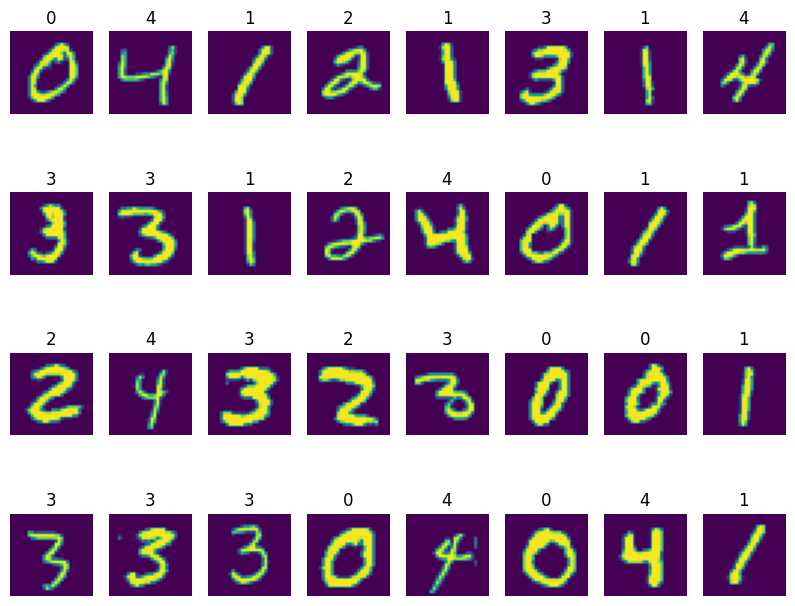

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

nrows=4
ncols=8
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 8))

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.imshow(X_train[i*ncols + j])
        ax.set_title(y_train[i*ncols + j])
        ax.axis('off')
plt.show()

In [13]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, callbacks=[checkpoints, early_stopping])

Epoch 1/30
957/957 [==============================] - 8s 5ms/step - loss: 0.1208 - accuracy: 0.9635 - val_loss: 1.7272 - val_accuracy: 0.0000e+00
Epoch 2/30
957/957 [==============================] - 5s 5ms/step - loss: 0.0595 - accuracy: 0.9838 - val_loss: 1.7858 - val_accuracy: 0.0000e+00
Epoch 3/30
957/957 [==============================] - 5s 5ms/step - loss: 0.0402 - accuracy: 0.9883 - val_loss: 1.8819 - val_accuracy: 0.0000e+00
Epoch 4/30
957/957 [==============================] - 5s 6ms/step - loss: 0.0376 - accuracy: 0.9901 - val_loss: 1.9045 - val_accuracy: 0.0000e+00
Epoch 5/30
957/957 [==============================] - 5s 6ms/step - loss: 0.0282 - accuracy: 0.9918 - val_loss: 2.0508 - val_accuracy: 0.0000e+00
Epoch 6/30
957/957 [==============================] - 5s 5ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 2.0533 - val_accuracy: 0.0000e+00
Epoch 7/30
957/957 [==============================] - 5s 5ms/step - loss: 0.0217 - accuracy: 0.9946 - val_loss: 2.1262 - val

In [14]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model, neurons=[100, 75, 50], verbose=1)

param_grid = {
    'optimizer': ['sgd', 'nadam', 'adam'],
    'neurons': [100, 75, 50],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

957/957 [==============================] - 8s 6ms/step - loss: 0.1188 - accuracy: 0.9649


In [15]:
grid_result.best_params_

{'neurons': 100, 'optimizer': 'sgd'}

In [39]:
def create_model(activation='elu', init='he_normal', neurons=100, optimizer='adam'):
    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=[28, 28,]))
    for _ in range(5):
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(neurons, activation=activation, kernel_initializer=init))
        
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(5, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [40]:
model = create_model()

In [41]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, callbacks=[checkpoints, early_stopping])

Epoch 1/10
957/957 [==============================] - 14s 10ms/step - loss: 0.1317 - accuracy: 0.9575 - val_loss: 3.2044 - val_accuracy: 0.0000e+00
Epoch 2/10
957/957 [==============================] - 8s 9ms/step - loss: 0.0655 - accuracy: 0.9792 - val_loss: 3.2516 - val_accuracy: 0.0000e+00
Epoch 3/10
957/957 [==============================] - 8s 9ms/step - loss: 0.0506 - accuracy: 0.9834 - val_loss: 5.7125 - val_accuracy: 0.0000e+00
Epoch 4/10
957/957 [==============================] - 8s 9ms/step - loss: 0.0440 - accuracy: 0.9869 - val_loss: 8.7342 - val_accuracy: 0.0000e+00
Epoch 5/10
957/957 [==============================] - 8s 9ms/step - loss: 0.0363 - accuracy: 0.9877 - val_loss: 8.1143 - val_accuracy: 0.0000e+00
Epoch 6/10
957/957 [==============================] - 9s 10ms/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 5.3691 - val_accuracy: 0.0000e+00
Epoch 7/10
957/957 [==============================] - 9s 9ms/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 7.3640 - 

In [42]:
def create_model(activation='elu', init='he_normal', neurons=100, optimizer='adam'):
    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=[28, 28,]))
    for _ in range(5):
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(neurons, activation=activation, kernel_initializer=init))
        model.add(keras.layers.Dropout(0.5))
        
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(5, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [43]:
model = create_model()

In [44]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, callbacks=[checkpoints, early_stopping])

Epoch 1/10
957/957 [==============================] - 18s 12ms/step - loss: 0.5508 - accuracy: 0.8117 - val_loss: 2.3757 - val_accuracy: 0.0000e+00
Epoch 2/10
957/957 [==============================] - 10s 11ms/step - loss: 0.2490 - accuracy: 0.9282 - val_loss: 2.1103 - val_accuracy: 0.0000e+00
Epoch 3/10
957/957 [==============================] - 10s 11ms/step - loss: 0.2466 - accuracy: 0.9275 - val_loss: 2.4620 - val_accuracy: 0.0000e+00
Epoch 4/10
957/957 [==============================] - 11s 11ms/step - loss: 0.2141 - accuracy: 0.9394 - val_loss: 4.2418 - val_accuracy: 0.0000e+00
Epoch 5/10
957/957 [==============================] - 11s 11ms/step - loss: 0.1910 - accuracy: 0.9460 - val_loss: 3.6112 - val_accuracy: 0.0000e+00
Epoch 6/10
957/957 [==============================] - 11s 11ms/step - loss: 0.1753 - accuracy: 0.9512 - val_loss: 4.0694 - val_accuracy: 0.0000e+00
Epoch 7/10
957/957 [==============================] - 10s 11ms/step - loss: 0.1575 - accuracy: 0.9557 - val_loss